In [279]:
%cd /nethome/bdevnani3/vis_lang/zero_shot

/nethome/bdevnani3/vis_lang/zero_shot


In [326]:
from base import *
from main import *
import utils
import umap

root_path = utils.init_root()
d = {}

In [331]:
LOSS = "dot" # "clip", "dot", "cossim"
METRIC = "cosine" # cosine, euclidean
EXP_NAME = LOSS + " loss"

########################################

from omegaconf import OmegaConf
args = OmegaConf.load(f'/nethome/bdevnani3/vis_lang/zero_shot/configs/bert_cifar10_{LOSS}.yml')
exp = main(args, train=False)

state, exp_name = (torch.load(f'/nethome/bdevnani3/raid/zero_shot/bert_cifar10_{LOSS}/models/best_acc.pth', map_location=torch.device('cpu')), EXP_NAME)
exp.model.load_state_dict(state['net'])

print(state["acc"])

class_embeddings = exp.model.word_lookup.cpu().numpy()
embeddings = [[] for _ in range(len(exp.class_names))]
classes_finished = 0


NUM_EMBEDDINGS_PER_CLASS = 100

for inputs, labels in exp.test_loader:
    with torch.no_grad():
        embedding = exp.model(inputs).cpu().numpy()

    for i, label in enumerate(labels):
        if len(embeddings[label]) < NUM_EMBEDDINGS_PER_CLASS:
            embeddings[label].append(embedding[i])
            
            # Done with this class
            if len(embeddings[label]) == NUM_EMBEDDINGS_PER_CLASS:
                classes_finished += 1
    
    if classes_finished >= len(exp.class_names):
        break
    d[LOSS] = embeddings

Files already downloaded and verified
Files already downloaded and verified
Initializing stsb-bert-base...
94.36


In [337]:
words_proj = np.concatenate([class_embeddings] + [np.stack(x, axis=0) for x in d["cossim"]] + [np.stack(x, axis=0) for x in d["dot"]] + [np.stack(x, axis=0) for x in d["clip"]], axis=0)
print(words_proj.shape)
reducer = umap.UMAP(metric=METRIC, n_neighbors=20, min_dist=0.5)
model = reducer.fit(words_proj)
words_proj = model.transform(words_proj)
print(words_proj.shape)
class_proj = words_proj[:len(exp.class_names)]
words_proj = words_proj[len(exp.class_names):]
print(words_proj.shape)
embedding_projs = [None] * len(exp.class_names)

for class_idx in range(len(exp.class_names)):
    embedding_projs[class_idx] = words_proj[:NUM_EMBEDDINGS_PER_CLASS]
    words_proj = words_proj[NUM_EMBEDDINGS_PER_CLASS:]

(3010, 768)
(3010, 2)
(3000, 2)


In [316]:
def plot(embedding_projs, class_proj, exp_name):
    import seaborn as sns
    sns.set(style='white', context='poster')

    fig = plt.figure(figsize=(14, 14))
    ax = fig.add_subplot(1, 1, 1)
    ax.tick_params(left=False,
                    bottom=False, 
                    labelleft=False,
                    labelbottom=False)

    cs = []
    for i, name in enumerate(exp.class_names):
        p = ax.plot(embedding_projs[i][:, 0], embedding_projs[i][:, 1], '.', markersize=5,label=name, zorder=1)
        cs.append(p[0].get_color())

    for i, name in enumerate(exp.class_names):
        ax.annotate(name, (class_proj[i, 0] + 0.1, class_proj[i, 1] + 0.1))

    for i, name in enumerate(exp.class_names):
        ax.scatter([class_proj[i, 0]], [class_proj[i, 1]], marker='^', color=cs[i], s=200, edgecolor="k", zorder=2)

    # ax.legend()
    plt.title(exp_name + ' Embedding Space')

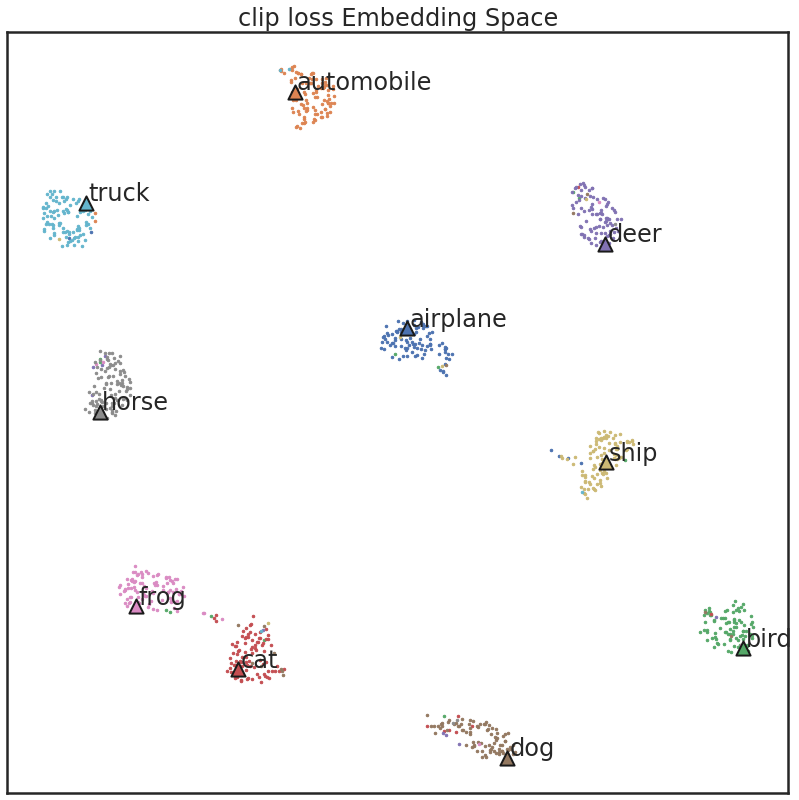

In [312]:
plot(embedding_projs, class_proj, exp_name)

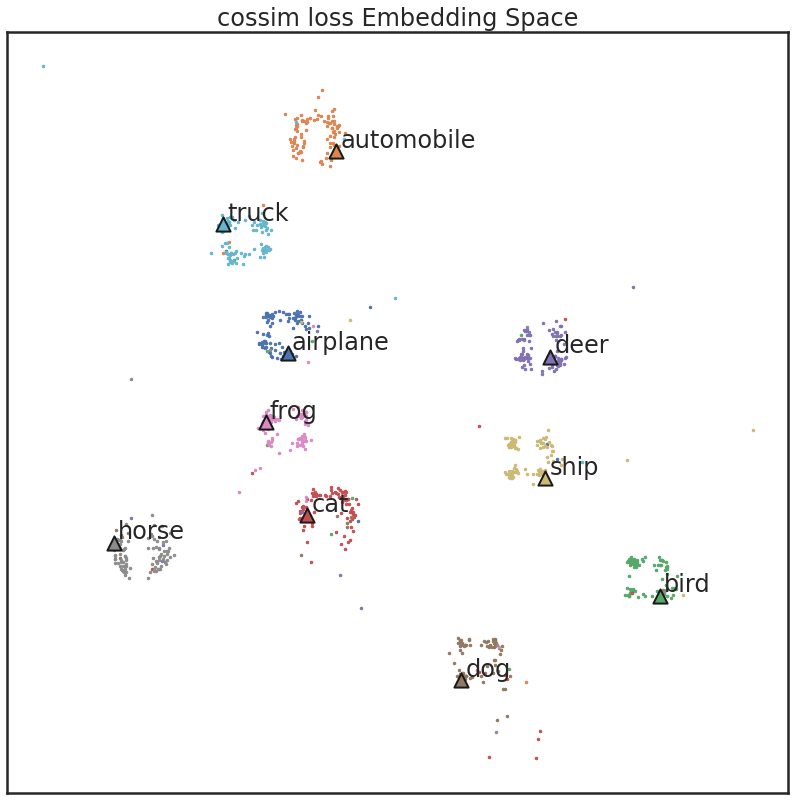

In [314]:
plot(embedding_projs, class_proj, exp_name)

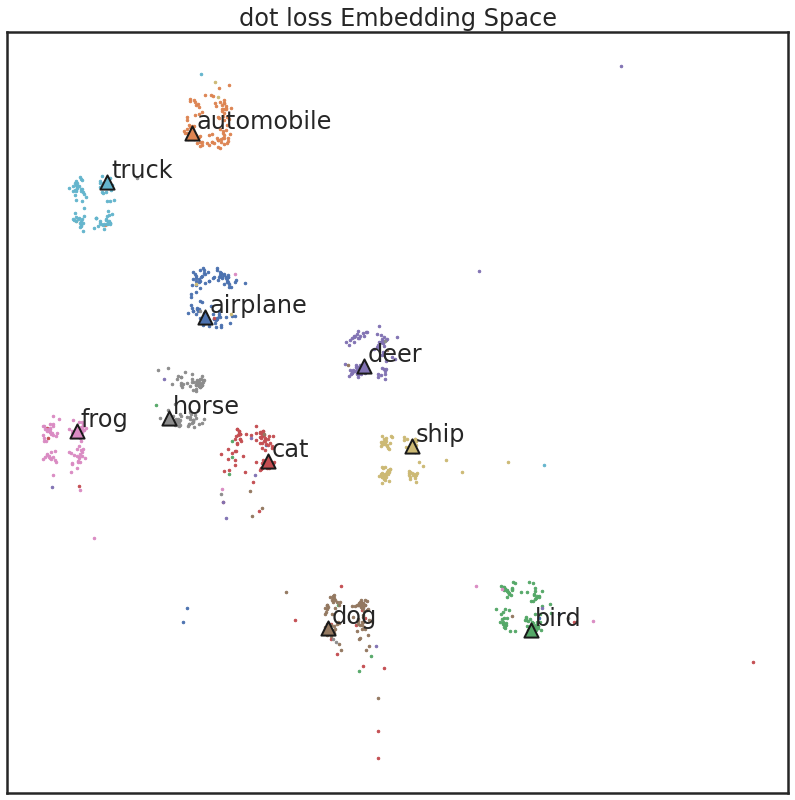

In [317]:
plot(embedding_projs, class_proj, exp_name)